### QAOA with real data

QTFT Team, 23/05/2020
- No divide and conquer yet
- Communities are breakdown into <10 assets with greedy modularity and Louvian algorithms
- QAOA is simulated using tensor network and w-state anzat
- Linear relaxation is used as a classical benchmark

In [1]:
import numpy as np
from qaoa_tn import Relaxation, Relaxation_RoundUp, Exact
from qaoa_dc import QAOA_DC, NearNode_DC_QAOA
from qaoa_dc import LGP, QSR2, get_bit, get_dict, _getCost
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy import sparse
import networkx as nx
import community
import random
#import func

Load data

In [2]:
As = sparse.load_npz('data/a_matrix.npz')
Qs = sparse.load_npz('data/q_matrix.npz')

Create subgroup

Group size distribution according to greedy modularity algorithm


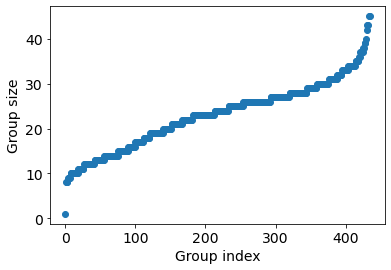

Size of the selected group: 8


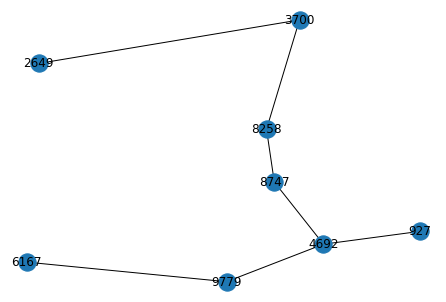

Subgroup size distribution according to Louvian algorithm 


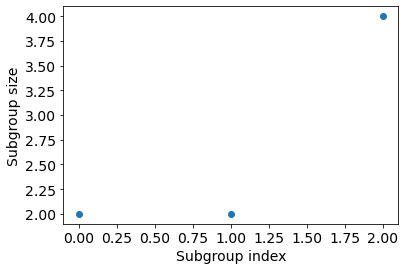

Size of the selected subgroup: 2


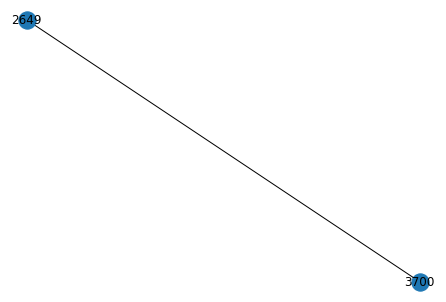

In [3]:
# Create cgroups using greedy modularity communities
As_nx = nx.from_scipy_sparse_matrix(As)
groups = nx.algorithms.community.modularity_max.greedy_modularity_communities(As_nx)

# Randomly select a group
idx = random.choice(groups)
while len(idx) > 12:
    idx = random.choice(groups)
G = As_nx.subgraph(idx)
asset_idx = G.nodes()

# Create subgroups using Louvain algorithm
subgroups = community.best_partition(G)

# Randomly select a subgroup
keys = np.array(list(subgroups.keys()))
vals = np.array(list(subgroups.values()))
asset_idx = keys[np.where(vals==np.random.randint(max(vals)))[0]]
g = As_nx.subgraph(asset_idx)


print("Group size distribution according to greedy modularity algorithm")
plt.figure()
plt.plot(np.sort([len(x) for x in groups]),'o')
plt.xlabel('Group index',fontsize=14)
plt.ylabel('Group size',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


print("Size of the selected group: %d"%len(G))
plt.figure()
nx.draw(G, with_labels = True)
plt.show()


print("Subgroup size distribution according to Louvian algorithm ")
plt.figure()
plt.plot(np.sort(np.unique(vals,return_counts=True)[1]),'o')
plt.xlabel('Subgroup index',fontsize=14)
plt.ylabel('Subgroup size',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


print("Size of the selected subgroup: %d"%len(g))
plt.figure()
nx.draw(g, with_labels = True)
plt.show()


Divide-and-Conquer QAOA with shared nearest neighbor method.
Dividing the big community by louvian algorithm does not provide subgroups containing shared nodes. Thus we have to manually add the nearest node, which is not in the same subgroup, as a shared node and vice versa.

Define list of subgroups to be solved by QAOA.

In [4]:
subgroups_list = []

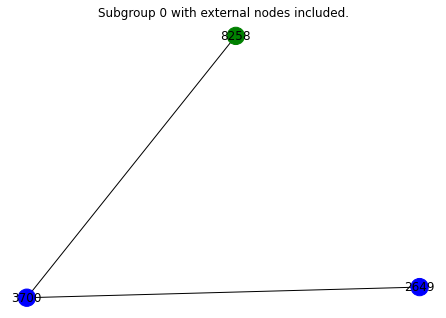

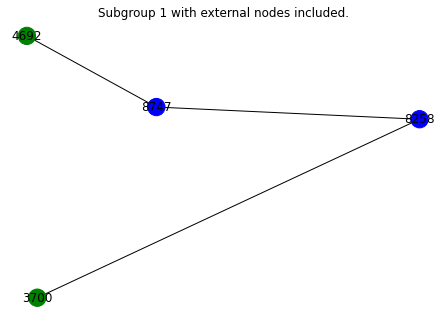

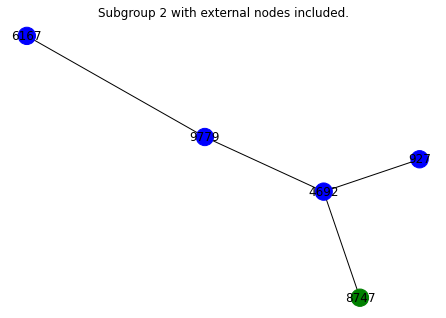

In [5]:
#Loop though each subgroups to get new subgroup including nearest neigher.
#Original subgroup.
for subgroup in np.unique(vals):
    asset_idx = keys[np.where(vals==subgroup)[0]]
    asset_idx_old = asset_idx #For coloring
    g = As_nx.subgraph(asset_idx)
    """
    plt.figure()
    nx.draw(g, with_labels = True)
    plt.title("Subgroup "+str(subgroup)+".")
    plt.show()
    """
#Check each assets for any external edge.
#Add an indice of external asset into asset_idx and recreate new subgroup.
    edges_ext = [] #Need this line to prevent memory bug.
    for asset in g.nodes:
        if len(G.edges(asset)) != len(g.edges(asset)):
            edges_ext = [int(v) for (u,v) in list(G.edges(asset)) if (u,v) not in list(g.edges(asset)) ]
        asset_idx = np.append(asset_idx, edges_ext)
    asset_idx = np.unique(asset_idx).astype('int') #Ensure no duplicated asset index.
    g = As_nx.subgraph(asset_idx)
    
    nodes_ext = [ext for ext in asset_idx if ext not in asset_idx_old]
    colors = ['g' if node in nodes_ext else 'b' for node in g.nodes() ]

    plt.figure()
    nx.draw(g, with_labels = True, node_color=colors)
    plt.title("Subgroup "+str(subgroup)+" with external nodes included.")
    plt.show()

    subgroups_list.append(asset_idx)

Solve each subgroups with QAOA.
QAOA needs only asset_idx, no graph g needed.

In [6]:
for count, idx_list in enumerate(subgroups_list):
    print(count, idx_list)
shared = np.intersect1d(subgroups_list[2], subgroups_list[1])

0 [2649 3700 8258]
1 [3700 4692 8258 8747]
2 [ 927 4692 6167 8747 9779]


In [7]:
numCandidates = 50
cycles = 2
cnt_result = NearNode_DC_QAOA(subgroups_list, Qs, As, cycles=cycles, numCandidates=numCandidates)

         Current function value: -17.167574
         Iterations: 20
         Function evaluations: 130
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -16.660347
         Iterations: 16
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -20.401625
         Iterations: 17
         Function evaluations: 110
         Gradient evaluations: 22


Try Quantum State Reconstruction.

*** When we use asset_idx, string ordering is not important so we can use np.unique with no proble. However, in QSR2 we use indexing which requires strings to be correct order. Check this if having enough time. 

***Error no shared nodes in some graphs. Do QSR recursively not just one time loop to prevent it.

In [12]:
group_final = subgroups_list[0]
cnt_final = cnt_result[0]

#Construct state using results of each subgroups.

while len(subgroups_list) > 1:
    loop_idx = 1
    while loop_idx < len(subgroups_list):
        if len(np.intersect1d(group_final, subgroups_list[loop_idx]) ) != 0:            
            cnt_final = QSR2(group_final, subgroups_list[loop_idx], cnt_final, cnt_result[loop_idx], numCandidates=numCandidates)
            group_final = np.unique(list(group_final) + list(subgroups_list[loop_idx]))
            #Remove subgroup that already be reconstructed.
            del subgroups_list[loop_idx], cnt_result[loop_idx]
            break
        #Check the next subgroup.
        loop_idx += 1

#    for ii in range(1, len(subgroups_list)):
        #Check for sharing assets.
#        if np.intersect1d(group_final, subgroups_list[ii]) != 0:
#            cnt_final = QSR2(group_final, subgroups_list[ii], cnt_final, cnt_result[ii], numCandidates=numCandidates)
#            group_final = np.unique(list(group_final) + list(subgroups_list[ii]))
            
#        else:
#            continue


Run Linear Round-up Relaxation 

In [9]:
N = len(G.nodes())
M = 7
action_idx = np.arange(M)
Q = np.array(Qs[G.nodes][:,action_idx].todense()) / 8000
A = np.array(As[G.nodes][:,G.nodes].todense())
e = 1
linear_roundup = Relaxation_RoundUp(N, M, Q, A, e)
linear_roundup.optimized(maxiter=300)

/Users/jirawat/opt/anaconda3/envs/kbtg/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/Users/jirawat/opt/anaconda3/envs/kbtg/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
`xtol` termination condition is satisfied.
Number of iterations: 131, function evaluations: 640, CG iterations: 0, optimality: 1.25e-01, constraint violation: 0.00e+00, execution time: 0.46 s.


Run Linear Relaxation

In [14]:
N = len(G.nodes())
M = 7
action_idx = np.arange(M)
Q = np.array(Qs[G.nodes][:,action_idx].todense()) / 8000
A = np.array(As[G.nodes][:,G.nodes].todense())
e = 1
linear = Relaxation(N, M, Q, A, e)
linear.optimized(maxiter=300)

`xtol` termination condition is satisfied.
Number of iterations: 129, function evaluations: 512, CG iterations: 0, optimality: 1.50e-01, constraint violation: 0.00e+00, execution time: 0.45 s.


In [15]:

cost_dc = []
print("20 states with hightest probability. \n")
for state, prob_den in list(cnt_final.items())[0:20]:
    prob = prob_den*prob_den.conj()/len(G)
    cost = _getCost(state, Q, A, e)
    print("%s with cost %.3f"%(state, cost))
    cost_dc.append(cost)


20 states with hightest probability. 

530004025 with cost -30.165
530404025 with cost -25.215
530004425 with cost -30.063
530014025 with cost -26.829
550004025 with cost -30.165
530004005 with cost -32.098
530414025 with cost -21.879
550404025 with cost -25.215
530002025 with cost -31.396
530000025 with cost -36.507
550014025 with cost -26.829
530014425 with cost -26.728
530044425 with cost -25.690
530404005 with cost -27.035
530004405 with cost -31.996
530014005 with cost -28.762
330004025 with cost -30.216
550414025 with cost -21.879
550004005 with cost -32.098
530402025 with cost -26.446


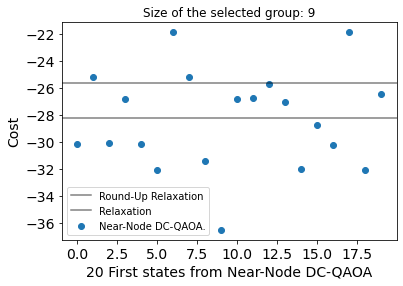

In [16]:
plt.axhline(y=linear_roundup.cost_min, linestyle='-',alpha=0.5, c='k',label='Round-Up Relaxation')
plt.axhline(y=linear.cost_min, linestyle='-',alpha=0.5, c='k',label='Relaxation')
plt.scatter(x=range(len(cost_dc)), y=cost_dc, label="Near-Node DC-QAOA.")
#plt.plot(qaoa.costs, label='QAOA')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Size of the selected group: %d"%len(G))
plt.xlabel('20 First states from Near-Node DC-QAOA',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.legend()